In [ ]:
import numpy as np
import pandas as pd
import math
import sklearn.preprocessing
import datetime
from TimeBasedCV import TimeBasedCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import make_scorer, r2_score
import warnings
import statsmodels.api as sm
warnings.simplefilter(action='ignore', category=Warning)
import pickle
import matplotlib.pyplot as plt

In [2]:
# df = pd.read_csv('data/factors_1965.csv', parse_dates=['DATE'])

In [3]:
# with open('data/features_1965.pkl', 'wb') as f:
#     pickle.dump(df, f)

with open('data/features_1965.pkl', 'rb') as f:
    df = pickle.load(f)
    print(df.head())

   permno       DATE        mvel1      beta    betasq     chmom     dolvol  \
0   10145 1965-02-26   1498872.00  0.983510  0.967291  0.105988  11.546907   
1   10401 1965-02-26  35392058.00  0.780829  0.609694 -0.063768  12.240330   
2   10786 1965-02-26   1695284.75  0.806119  0.649827 -0.130519  12.005040   
3   10989 1965-02-26   1295887.75  1.199748  1.439395  0.073609  11.756961   
4   11260 1965-02-26   2302001.25  1.257269  1.580725 -0.167320  12.240330   

    idiovol    indmom     mom1m  ...  macro_ep  macro_bm  macro_ntis  \
0  0.022307  0.035075  0.104116  ...  2.936836  0.471399    0.014823   
1  0.013395  0.335139 -0.007326  ...  2.936836  0.471399    0.014823   
2  0.024366  0.104106  0.060498  ...  2.936836  0.471399    0.014823   
3  0.022717  0.118513  0.068807  ...  2.936836  0.471399    0.014823   
4  0.035883  0.185424 -0.036885  ...  2.936836  0.471399    0.014823   

   macro_tbl  macro_tms  macro_dfy  macro_svar  macro_mkt-rf  macro_hml  \
0     0.0393    -0.0379

In [ ]:

df[df.columns[2:]] = df[df.columns[2:]].astype('float32')
df = df.sort_values(by = ['DATE', 'permno'], ascending = True)
df.head()


,permno,DATE,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,mom1m,...,macro_ep,macro_bm,macro_ntis,macro_tbl,macro_tms,macro_dfy,macro_svar,macro_mkt-rf,macro_hml,macro_smb
0,10145,1965-02-26,1498872.00,0.983510,0.967291,0.105988,11.546906,0.022307,0.035075,0.104116,...,2.936836,0.471399,0.014823,0.0393,-0.0379,0.0055,0.000393,0.44,0.11,3.55
1,10401,1965-02-26,35392056.00,0.780829,0.609694,-0.063768,12.240331,0.013395,0.335139,-0.007326,...,2.936836,0.471399,0.014823,0.0393,-0.0379,0.0055,0.000393,0.44,0.11,3.55
2,10786,1965-02-26,1695284.75,0.806119,0.649827,-0.130519,12.005040,0.024366,0.104106,0.060498,...,2.936836,0.471399,0.014823,0.0393,-0.0379,0.0055,0.000393,0.44,0.11,3.55
3,10989,1965-02-26,1295887.75,1.199748,1.439395,0.073609,11.756961,0.022717,0.118513,0.068807,...,2.936836,0.471399,0.014823,0.0393,-0.0379,0.0055,0.000393,0.44,0.11,3.55
4,11260,1965-02-26,2302001.25,1.257269,1.580725,-0.167320,12.240331,0.035883,0.185424,-0.036885,...,2.936836,0.471399,0.014823,0.0393,-0.0379,0.0055,0.000393,0.44,0.11,3.55


In [ ]:
df['permno2'] = df['permno'].copy()
df['DATE2'] = df['DATE'].copy()
df = df.set_index(['DATE2','permno2'])

df['mvel12'] = df['mvel1'].copy()

In [7]:
p=0.3
df_top= df.groupby('DATE').apply(lambda x: x.nlargest(int(len(x)*p),'mvel1')).reset_index(drop=True)  
df_bottom = df.groupby('DATE').apply(lambda x: x.nsmallest(int(len(x)*p),'mvel1')).reset_index(drop=True)  


In [8]:
features = df.columns[~df.columns.isin(['DATE', 'DATE2', "mvel2",'sic2' ,'permno',"permno2",'risk_premium'])].tolist()
df[features]=df.groupby('DATE')[features].rank(pct=True)
df[features] = 2*df[features] - 1

df_top[features]=df_top.groupby('DATE')[features].rank(pct=True)
df_top[features] = 2*df_top[features] - 1

df_bottom[features]=df_bottom.groupby('DATE')[features].rank(pct=True)
df_bottom[features] = 2*df_bottom[features] - 1

In [9]:
def calculate_r2(y_true, y_pred, in_sample=True, benchmark=None):
    if in_sample:
        return 1 - (np.sum((y_true - y_pred) ** 2) / 
                    np.sum((y_true - np.mean(y_true)) ** 2))
    else:
        if benchmark is None:
            raise ValueError("Benchmark must be provided for out-of-sample R-squared calculation.")
        return 1 - (np.sum((y_true - y_pred) ** 2) / 
                    np.sum((y_true - benchmark) ** 2))

In [ ]:
tscv = TimeBasedCV(train_period=120,
                   val_period=24,
                   test_period=12,
                   freq='months')

features = df.columns[~df.columns.isin(['permno', 'permno2', 'mvel12','sic2', 'DATE2', 'risk_premium'])].tolist()

X = df[features]
y = df[['risk_premium']]

X_train = sm.add_constant(X)

predictions = []
y_test_list =[]
dates = []
dic_r2_all = {}


for train_index, val_index, test_index in tscv.split(X, first_split_date= datetime.date(1975,1,31), second_split_date= datetime.date(1985,1,31)):

    X_train   = X.loc[train_index].drop('DATE', axis=1)
    y_train = y.loc[train_index]
    
    X_val   = X.loc[val_index].drop('DATE', axis=1)
    y_val = y.loc[val_index]

    X_test    = X.loc[test_index].drop('DATE', axis=1)
    y_test  = y.loc[test_index]
    
    lm = LinearRegression()
    lm.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
    preds = lm.predict(X_test) 
    predictions.append(preds)
    dates.append(y_test.index)
    y_test_list.append(y_test)
    
    r2 = 1-np.sum(pow(y_test-preds,2))/np.sum(pow(y_test,2))
    dic_r2_all["r2." + str(y_test.index)] = r2
   
    
    
predictions_all= np.concatenate(predictions, axis=0)
y_test_list_all= np.concatenate(y_test_list, axis=0) 
dates_all= np.concatenate(dates, axis=0)

R2OOS_LR = 1-np.sum(pow(y_test_list_all-predictions_all,2))/np.sum(pow(y_test_list_all,2))
print("R2OOS Linear Regression Full: ", R2OOS_LR)

Train period: 1965-01-31 - 1975-01-31 ,val period: 1975-01-31 - 1977-01-31 , Test period 1977-01-31 - 1978-01-31 # train records 13670 ,# val records 3499 , # test records 1941
Train period: 1966-01-31 - 1976-01-31 ,val period: 1976-01-31 - 1978-01-31 , Test period 1978-01-31 - 1979-01-31 # train records 14434 ,# val records 3708 , # test records 2030
Train period: 1967-01-31 - 1977-01-31 ,val period: 1977-01-31 - 1979-01-31 , Test period 1979-01-31 - 1980-01-31 # train records 15118 ,# val records 3971 , # test records 2358
Train period: 1968-01-31 - 1978-01-31 ,val period: 1978-01-31 - 1980-01-31 , Test period 1980-01-31 - 1981-01-31 # train records 15843 ,# val records 4388 , # test records 3334
Train period: 1969-01-31 - 1979-01-31 ,val period: 1979-01-31 - 1981-01-31 , Test period 1981-01-31 - 1982-01-31 # train records 16573 ,# val records 5692 , # test records 3578
Train period: 1970-01-31 - 1980-01-31 ,val period: 1980-01-31 - 1982-01-31 , Test period 1982-01-31 - 1983-01-31 # 

In [11]:
tscv = TimeBasedCV(train_period=120,
                   val_period=24,
                   test_period=12,
                   freq='months')

features = df.columns[~df.columns.isin(['permno', 'permno2', 'mvel12','sic2' 'DATE2', 'risk_premium'])].tolist()

X = df_top[features]
y = df_top[['risk_premium']]


predictions_top = []
y_test_list_top =[]
dates_top = []
dic_r2_all_top = {}

for train_index, val_index, test_index in tscv.split(X, first_split_date= datetime.date(1975,1,31), second_split_date= datetime.date(1985,1,31)):

    X_train   = X.loc[train_index].drop('DATE', axis=1)
    y_train = y.loc[train_index]
    
    X_val   = X.loc[val_index].drop('DATE', axis=1)
    y_val = y.loc[val_index]

    X_test    = X.loc[test_index].drop('DATE', axis=1)
    y_test  = y.loc[test_index]
    

    lm = LinearRegression()
    lm.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
    preds = lm.predict(X_test) 
    predictions_top.append(preds)
    dates_top.append(y_test.index)
    y_test_list_top.append(y_test)
    
    r2_top = 1-np.sum(pow(y_test-preds,2))/np.sum(pow(y_test,2))
    dic_r2_all_top["r2." + str(y_test.index)] = r2
   
    
    

predictions_all_top= np.concatenate(predictions_top, axis=0)
y_test_list_all_top= np.concatenate(y_test_list_top, axis=0) 
dates_all_top= np.concatenate(dates_top, axis=0)

R2OOS_LR_top = 1-np.sum(pow(y_test_list_all_top-predictions_all_top,2))/np.sum(pow(y_test_list_all_top,2))
print("R2OOS Linear Regression Top: ", R2OOS_LR_top)

Train period: 1965-01-31 - 1975-01-31 ,val period: 1975-01-31 - 1977-01-31 , Test period 1977-01-31 - 1978-01-31 # train records 4042 ,# val records 1040 , # test records 577
Train period: 1966-01-31 - 1976-01-31 ,val period: 1976-01-31 - 1978-01-31 , Test period 1978-01-31 - 1979-01-31 # train records 4271 ,# val records 1103 , # test records 603
Train period: 1967-01-31 - 1977-01-31 ,val period: 1977-01-31 - 1979-01-31 , Test period 1979-01-31 - 1980-01-31 # train records 4478 ,# val records 1180 , # test records 704
Train period: 1968-01-31 - 1978-01-31 ,val period: 1978-01-31 - 1980-01-31 , Test period 1980-01-31 - 1981-01-31 # train records 4696 ,# val records 1307 , # test records 995
Train period: 1969-01-31 - 1979-01-31 ,val period: 1979-01-31 - 1981-01-31 , Test period 1981-01-31 - 1982-01-31 # train records 4915 ,# val records 1699 , # test records 1068
Train period: 1970-01-31 - 1980-01-31 ,val period: 1980-01-31 - 1982-01-31 , Test period 1982-01-31 - 1983-01-31 # train rec

In [12]:
tscv = TimeBasedCV(train_period=120,
                   val_period=24,
                   test_period=12,
                   freq='months')


features = df.columns[~df.columns.isin(['permno', 'permno2', 'mvel12','sic2', 'DATE2', 'risk_premium'])].tolist()
X = df_bottom[features]
y = df_bottom["risk_premium"]

predictions_bottom = []
y_test_list_bottom =[]
dates_bottom = []
dic_r2_all_bottom = {}


for train_index, val_index, test_index in tscv.split(X, first_split_date= datetime.date(1975,1,31), second_split_date= datetime.date(1985,1,31)):

    X_train   = X.loc[train_index].drop('DATE', axis=1)
    y_train = y.loc[train_index]
    
    X_val   = X.loc[val_index].drop('DATE', axis=1)
    y_val = y.loc[val_index]

    X_test    = X.loc[test_index].drop('DATE', axis=1)
    y_test  = y.loc[test_index]
    

    lm = LinearRegression()
    lm.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
    preds = lm.predict(X_test) 
    predictions_bottom.append(preds)
    dates_bottom.append(y_test.index)
    y_test_list_bottom.append(y_test)
    
    r2_bottom = 1-np.sum(pow(y_test-preds,2))/np.sum(pow(y_test,2))
    dic_r2_all_bottom["r2." + str(y_test.index)] = r2
   
    
    

predictions_all_bottom= np.concatenate(predictions_bottom, axis=0)
y_test_list_all_bottom= np.concatenate(y_test_list_bottom, axis=0) 
dates_all_bottom= np.concatenate(dates_bottom, axis=0)

R2OOS_LR_bottom = 1-np.sum(pow(y_test_list_all_bottom-predictions_all_bottom,2))/np.sum(pow(y_test_list_all_bottom,2))
print("R2OOS Linear Regression Bottom: ", R2OOS_LR_bottom)

Train period: 1965-01-31 - 1975-01-31 ,val period: 1975-01-31 - 1977-01-31 , Test period 1977-01-31 - 1978-01-31 # train records 4042 ,# val records 1040 , # test records 577
Train period: 1966-01-31 - 1976-01-31 ,val period: 1976-01-31 - 1978-01-31 , Test period 1978-01-31 - 1979-01-31 # train records 4271 ,# val records 1103 , # test records 603
Train period: 1967-01-31 - 1977-01-31 ,val period: 1977-01-31 - 1979-01-31 , Test period 1979-01-31 - 1980-01-31 # train records 4478 ,# val records 1180 , # test records 704
Train period: 1968-01-31 - 1978-01-31 ,val period: 1978-01-31 - 1980-01-31 , Test period 1980-01-31 - 1981-01-31 # train records 4696 ,# val records 1307 , # test records 995
Train period: 1969-01-31 - 1979-01-31 ,val period: 1979-01-31 - 1981-01-31 , Test period 1981-01-31 - 1982-01-31 # train records 4915 ,# val records 1699 , # test records 1068
Train period: 1970-01-31 - 1980-01-31 ,val period: 1980-01-31 - 1982-01-31 , Test period 1982-01-31 - 1983-01-31 # train rec

In [13]:
chart = np.array([[R2OOS_LR],
                  [R2OOS_LR_top],
                  [R2OOS_LR_bottom]])

r2_lm = pd.DataFrame(chart, columns=['Linear Regression Full'],
                     index=['Full Sample', 'Large Firms', 'Small Firms'])

r2_lm

,Linear Regression Full
Full Sample,0.052701
Large Firms,0.067313
Small Firms,0.042786


In [14]:
r2_lm.to_csv(r'r2/lr_full.csv')

In [10]:
#Sort observations by date and stock id
features = df.columns[~df.columns.isin(['DATE', 'DATE2', "mvel2",'sic2' ,'permno',"permno2",'risk_premium', 'year'])].tolist()
df['year'] = df['DATE'].dt.year

X_train = df[features].loc[(df["year"]>=2013) & (df["year"]<=2018)]
y_train = df["risk_premium"].loc[(df["year"]>=2013) & (df["year"]<=2018)]

X_val = df[features].loc[(df["year"]>=2019) & (df["year"]<=2020)]
y_val = df["risk_premium"].loc[(df["year"]>=2019) & (df["year"]<=2020)]


lm = LinearRegression()
lm.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
preds = lm.predict(np.concatenate((X_train, X_val))) 

R2OOS_all = 1-np.sum(pow(np.concatenate((y_train, y_val))-preds,2))/np.sum(pow(np.concatenate((y_train, y_val)),2))
print(R2OOS_all)

0.03702344384425604


In [11]:
for j in features:
    globals()['df_' + str(j)] =  df.copy()
    globals()['df_' + str(j)][str(j)] = 0

In [12]:
dic = {}

    
for j in features:
    print(j)
    df_var = globals()['df_' + str(j)]
    
    X_train = df_var[features].loc[(df_var["year"]>=2013) & (df_var["year"]<=2018)]
    y_train = df_var["risk_premium"].loc[(df_var["year"]>=2013) & (df_var["year"]<=2018)]

    X_val = df_var[features].loc[(df_var["year"]>=2019) & (df_var["year"]<=2020)]
    y_val = df_var["risk_premium"].loc[(df["year"]>=2019) & (df_var["year"]<=2020)]
    
    lm_model = LinearRegression()
    lm_model.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
    preds = lm_model.predict(np.concatenate((X_train, X_val))) 

    R2OOS_var = 1-np.sum(pow(np.concatenate((y_train, y_val))-preds,2))/np.sum(pow(np.concatenate((y_train, y_val)),2))
    dic['R2OOS_' + str(j)] = R2OOS_var

mvel1
beta
betasq
chmom
dolvol
idiovol
indmom
mom1m
mom6m
mom12m
mom36m
pricedelay
turn
absacc
acc
age
agr
bm
bm_ia
cashdebt
cashpr
cfp
cfp_ia
chatoia
chcsho
chempia
chinv
chpmia
convind
currat
depr
divi
divo
dy
egr
ep
gma
grcapx
grltnoa
herf
hire
invest
lev
lgr
mve_ia
operprof
orgcap
pchcapx_ia
pchcurrat
pchdepr
pchgm_pchsale
pchquick
pchsale_pchinvt
pchsale_pchrect
pchsale_pchxsga
pchsaleinv
pctacc
ps
quick
rd
roic
salecash
saleinv
salerec
securedind
sgr
sin
sp
tang
tb
baspread
ill
maxret
retvol
std_dolvol
std_turn
zerotrade
macro_dp
macro_ep
macro_bm
macro_ntis
macro_tbl
macro_tms
macro_dfy
macro_svar
macro_mkt-rf
macro_hml
macro_smb
mvel12


In [ ]:
pd.DataFrame(dic.items())
imp=pd.DataFrame(dic.items(), columns=['Feature', 'R2OOS'])
imp["Feature"] = imp["Feature"].str[6:]

imp["red_R2OOS"] = R2OOS_all -imp["R2OOS"]
imp["var_imp"] = imp["red_R2OOS"]/sum(imp["red_R2OOS"])
imp=imp.sort_values(by = ['var_imp'], ascending = False)
imp.head()

,Feature,R2OOS,red_R2OOS,var_imp
33,dy,0.036721,0.000302,0.124550
1,beta,0.036813,0.000211,0.086952
2,betasq,0.036820,0.000203,0.083729
7,mom1m,0.036842,0.000182,0.074893
63,salerec,0.036881,0.000142,0.058751


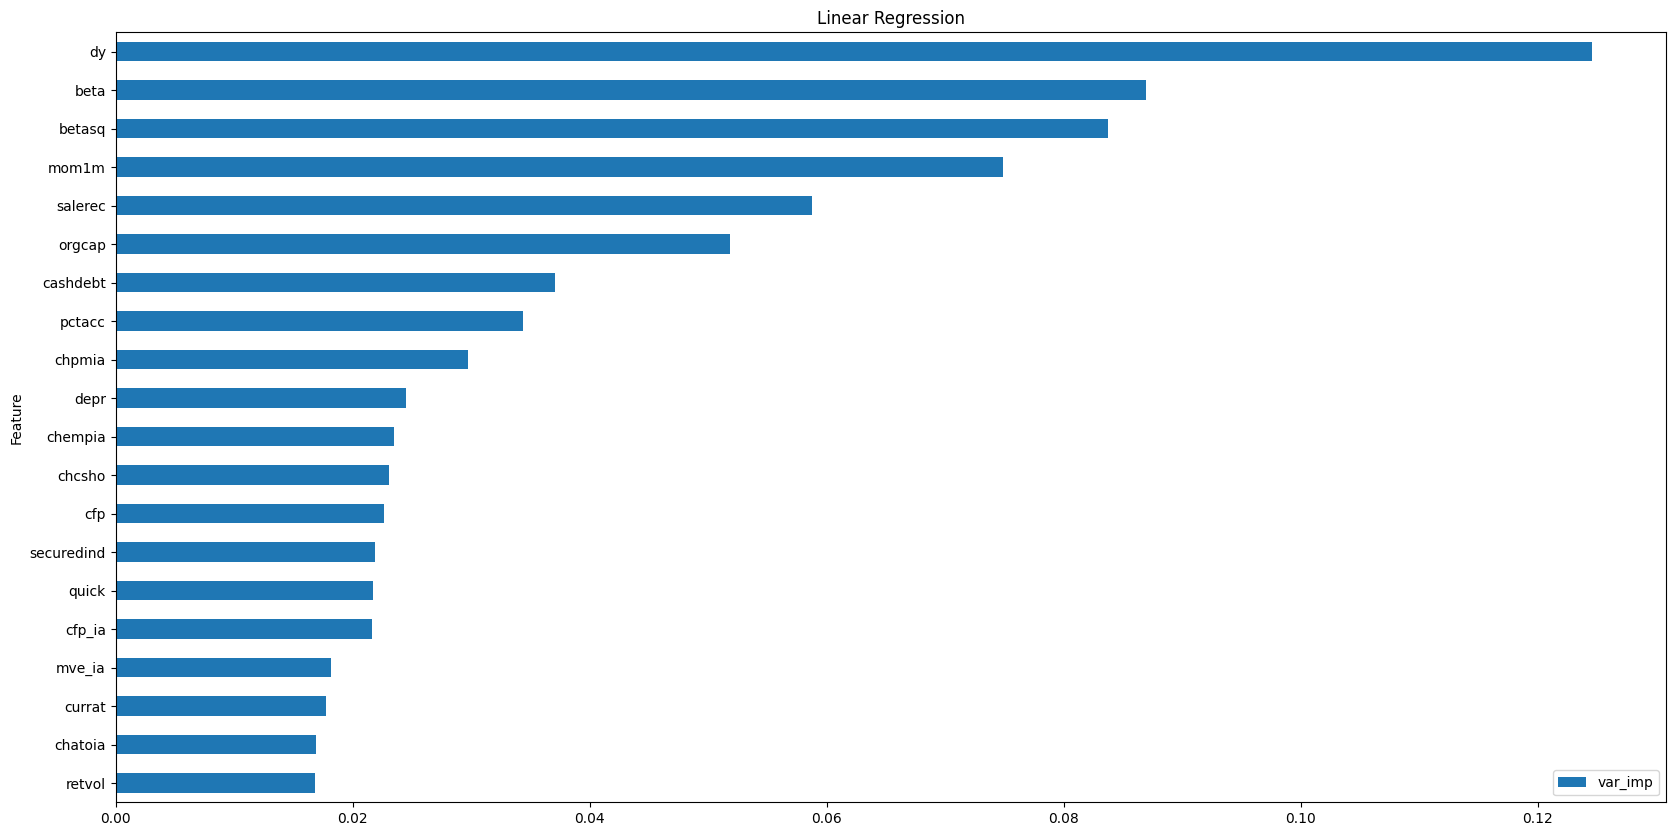

In [14]:
fea_imp_graph = imp.sort_values(['var_imp', 'Feature'], ascending=[True, False]).iloc[-20:]
_ = fea_imp_graph.plot(kind='barh', x='Feature', y='var_imp', figsize=(20, 10))
plt.title('Linear Regression')
plt.show()

In [15]:
var_imp_lm=imp[["Feature", "var_imp"]]
var_imp_lm.to_csv(r'var_imp_lm.csv', index = False)

In [115]:
yhat = predictions_all.tolist()
y_true = y_test_list_all.tolist()
i = dates_all.tolist()

results = pd.DataFrame(
    {'identifier': i,
     'yhat': yhat,
     'y_true': y_true
    })

results["identifier"]= results["identifier"].astype("str")
results["date"] = results["identifier"].str[12:22]
results["id"] = results["identifier"].str[35:40]
results.drop(["identifier"],axis = 1, inplace=True)
results['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
results['MonthYear'] = results['date'].dt.to_period('M')
results = results.sort_values(by = ['date', 'id'], ascending = True)
results = results.set_index(['MonthYear','id'])
results.head()

results['yhat'] = results['yhat'].apply(lambda x: x[0])
results['y_true'] = results['y_true'].apply(lambda x: x[0])

data = df[['mvel12', 'macro_tbl', 'macro_svar']].copy()
data.reset_index(inplace=True)
data['permno2'] = data['permno2'].astype('str')
data['MonthYear'] = data['DATE2'].dt.to_period('M')
data.drop('DATE2', axis=1, inplace=True)
data.rename(columns={'permno2': 'id'}, inplace=True)
data.rename(columns={'mvel12': 'market_cap'}, inplace=True)
data.rename(columns={'macro_tbl': 'risk_free_rate'}, inplace=True)
data = data.set_index(['MonthYear','id'])

bigdata = pd.merge(results, data,left_index=True, right_index=True)
bigdata.reset_index(inplace=True)
bigdata.head()
bigdata['returns'] = bigdata['y_true'] + bigdata['risk_free_rate']

In [ ]:
bigdata["monthyear1"]= bigdata["monthyear"].copy()
bigdata["monthyear"]= bigdata["monthyear"].astype("int64")
bigdata["nummonth"]= bigdata["monthyear"] - 83
bigdata["nummonth"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [117]:
bigdata

,MonthYear,id,yhat,y_true,date,market_cap,risk_free_rate,macro_svar,returns,MonthYear1,NumMonth
0,84,10145,-6.495025,10.2800,1977-01-31,-0.726190,0.005952,0.005952,10.285952,1977-01,1
1,84,10161,-7.069172,-13.0882,1977-01-31,0.035714,0.005952,0.005952,-13.082247,1977-01,1
2,84,10225,-7.375538,-6.3593,1977-01-31,-0.630952,0.005952,0.005952,-6.353348,1977-01,1
3,84,10401,-6.330769,-4.9169,1977-01-31,0.988095,0.005952,0.005952,-4.910948,1977-01,1
4,84,10604,-5.502393,-9.4819,1977-01-31,0.773810,0.005952,0.005952,-9.475948,1977-01,1
...,...,...,...,...,...,...,...,...,...,...,...
637109,612,93393,-1.046319,-5.4710,2021-01-29,-0.964940,0.000398,0.000398,-5.470602,2021-01,529
637110,612,93419,-1.178896,-2.4747,2021-01-29,-0.098805,0.000398,0.000398,-2.474302,2021-01,529
637111,612,93423,-1.781652,0.2333,2021-01-29,-0.258167,0.000398,0.000398,0.233698,2021-01,529
637112,612,93427,-0.974088,1.6799,2021-01-29,-0.267729,0.000398,0.000398,1.680298,2021-01,529


In [118]:
bigdata.to_csv('predictions/lm_full.csv', index=False)

In [1]:
import pandas as pd
import numpy as np
bigdata = pd.read_csv('predictions/lm_full.csv')

In [2]:
top_100 = bigdata.sort_values(['NumMonth','yhat'], ascending=[True, True]).groupby(['MonthYear'],
                                                                  as_index=False,
                                                                  sort=False).tail(100)

In [3]:
portfolio = top_100[['date', 'NumMonth','MonthYear', 'id', 'yhat', 'y_true', 'risk_free_rate', 'MonthYear1']]
portfolio.reset_index(inplace=True)
portfolio.drop(columns=['index'],inplace=True)
portfolio['eq_weights'] = 1/portfolio.groupby('MonthYear')['id'].transform('size')
portfolio['excess_return_stock_ew'] = portfolio['y_true'] *portfolio['eq_weights']
portfolio['pred_excess_return_stock_ew'] = portfolio["yhat"]*portfolio["eq_weights"]

C:\Users\drebi\AppData\Local\Temp\ipykernel_138184\4222648645.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio.drop(columns=['index'],inplace=True)
C:\Users\drebi\AppData\Local\Temp\ipykernel_138184\4222648645.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio['eq_weights'] = 1/portfolio.groupby('MonthYear')['id'].transform('size')
C:\Users\drebi\AppData\Local\Temp\ipykernel_138184\4222648645.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [4]:
mean_pred_return = portfolio.groupby('MonthYear')['pred_excess_return_stock_ew'].transform('sum').mean()
mean_port_return = portfolio.groupby('MonthYear')['excess_return_stock_ew'].transform('sum').mean()
port_vol =  portfolio.groupby('MonthYear')["pred_excess_return_stock_ew"].transform('sum').std()
sharp_ratio = (mean_pred_return/port_vol)*np.sqrt(12)

In [5]:
chart_np = np.array([[mean_port_return, mean_pred_return, port_vol, sharp_ratio]])

ew_df = pd.DataFrame(chart_np, columns=['Real', 'Pred', 'Std', 'Sharpe'],
                                index=['Linear Regression-Full'])

ew_df['Real'] = pd.Series(['{0:.2f}%'.format(val) for val in ew_df['Real']], index= ew_df.index)
ew_df['Pred'] = pd.Series(['{0:.2f}%'.format(val) for val in ew_df['Pred']], index= ew_df.index)
ew_df['Std'] = pd.Series(['{0:.2f}%'.format(val) for val in ew_df['Std']], index= ew_df.index)
ew_df['Sharpe'] = pd.Series(['{0:.2f}%'.format(val) for val in ew_df['Sharpe']], index= ew_df.index)
ew_df


,Real,Pred,Std,Sharpe
Linear Regression-Full,-3.26%,-3.79%,3.21%,-4.09%
